# Homework 1

## Vladimir Sydorskyi (KA-61)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

# Fix random 

In [2]:
np.random.seed(42)
sns.set() #set graphics options to default

# Initialize parameters

\begin{align}
\ m_k \sim N(0,1) \\
\ reward_k \sim N(m_k,1) \\
\end{align}

In [3]:
k = 10 # number of arms
monte_carlo_steps = 2000 # number of experiments
max_itters = 1000 # maximum steps

In [4]:
class BanditsArm(object):
    def __init__(self, mu, sigma = 1, reward = np.random.normal):
        self.mu = mu
        self.sigma = sigma
        self.reward = reward
    
    def get_reward(self):
        return self.reward(self.mu,self.sigma)
        
class KHandedBandit(object):
    def __init__(self, params):
        "Return a new bandit object"
        self.k = len(params)
        self.arms = [BanditsArm(**param) for param in params]
        self.bandits_mu = [b.mu for b in self.arms]
        
    def plot_sample_bandit(self, n = 10000, figsize = (8,8)):
        "Plot arms of bandit distribution"
        df = pd.DataFrame({"Arm_"+str(i):[arm.get_reward() for _ in range(n)] for i,arm in zip(range(len(self.arms)),self.arms)})
        plt.figure(figsize = figsize)
        sns.violinplot(data = df);
        
    def get_reward(self, A_k):
        "Get the reward from bandit for action - choosing arm A"
        return self.arms[A_k].get_reward()
    
    def get_best_arm(self):
        return np.argmax(self.bandits_mu)

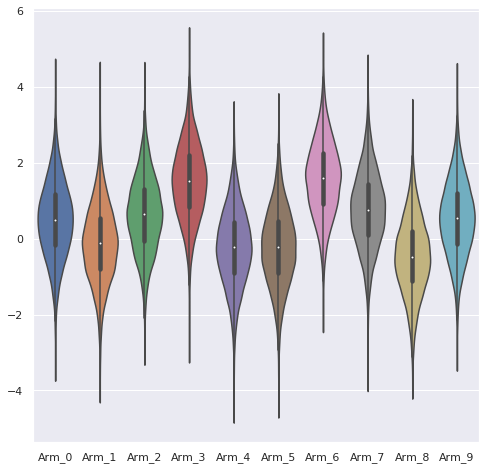

In [5]:
value_of_action = [{
    'mu':np.random.normal()
} for i in range(k)]

bandyt = KHandedBandit(value_of_action)
bandyt.plot_sample_bandit()

# Algorithm

### Initialization

\begin{align}
\ \vec{StatsMean_0} = \vec0 + InitialValue \\
\ \vec{StatsStep_0} = \vec0
\end{align}

### Compute Action(winner) and Reward

\begin{align}
\ ToExplore \sim Bin(1, epsilon) \\
\ ExploreCandidant \sim UD(BanditHeands) \\
\ winner_i = UD(argmax(\vec{StatsMean_{i-1}})) * (1 - ToExplore) +  ExploreCandidant * ToExplore \\
\ reward_i \sim N(m_{winner_i}, 1) \\
\end{align}

Where UD is a Discrete Unifrom distribution defined on a set of numbers 

### Recompute training stats

\begin{align}
\ {StatsMean_{i,winner_i}} = ({StatsMean_{i-1,winner_i}} * StatsStep_{i-1,winner_i} + reward_i) / (StatsStep_{i-1,winner_i} + 1) \\
\ {StatsMean_{i,winner_i}} = {StatsMean_{i-1,winner_i}} + 1
\end{align}

First index is a timestamp and second is a vector index

In [6]:
class Algorithm(object):
    def __init__(self, bandit, explore_epsilon=0., initial_value=0.):
        self.bandit = bandit
        self.n_heands = bandit.k
        
        self.stats_mean = np.array([0.]*self.n_heands) + initial_value
        self.stats_step = np.array([0]*self.n_heands)
        
        self.explore_epsilon = explore_epsilon
        
    def explore_func(self, winners):
        if np.random.binomial(n=1, p=self.explore_epsilon):
            return np.random.randint(0,self.n_heands)
        else:
            return np.random.choice(winners)
        
    def step(self):
        winners = np.argwhere(self.stats_mean == np.amax(self.stats_mean)).flatten()
        winner = self.explore_func(winners)
        
        reward = self.bandit.get_reward(winner)
        
        self.stats_mean[winner] = ((self.stats_mean[winner] * self.stats_step[winner]) + reward) / (self.stats_step[winner] + 1)
        self.stats_step[winner] += 1
        return winner, reward
    
    def train_cycle(self, max_itter):
        rewards = []
        choices = []
        for itter in range(max_itter):
            c,r = self.step()
            rewards.append(r)
            choices.append(c)
            
        right_choices_percentage = np.cumsum(np.array(choices) == self.bandit.get_best_arm()) /  np.arange(1,len(rewards)+1)
        mean_rewards = np.cumsum(rewards) / np.arange(1,len(rewards)+1)
            
        return rewards, mean_rewards, choices, right_choices_percentage
    
    def reset(self):
        self.stats_mean = np.array([0.]*self.n_heands)
        self.stats_step = np.array([0]*self.n_heands)

# Experiments

### Carry out

In [7]:
exp_grid ={
    'eps':[0., 0.1, 0.01],
    'initial_value':[0., 5.]
}
results = []

In [8]:
for e in tqdm(exp_grid['eps']):
    for q in tqdm(exp_grid['initial_value']):
        
        t_r = []
        t_c = []
        
        for i in tqdm(range(monte_carlo_steps)):
            # initialize objects
            bandit = KHandedBandit(value_of_action)
            casino = Algorithm(bandit,explore_epsilon=e, initial_value=q)
            
            _, tt_r, _, tt_c = casino.train_cycle(max_itters)
            t_r.append(np.array(tt_r))
            t_c.append(np.array(tt_c))
            
        results.append([e,q,np.array(t_r).mean(axis=0),np.array(t_c).mean(axis=0)])

### Analyze results

In [10]:
result_df = pd.DataFrame({
    'eps':[el[0] for el in results],
    'initial_value':[el[1] for el in results],
    'results_reward':[el[2] for el in results],
    'results_choice':[el[3] for el in results]
})

\begin{align}
\ RightChoice_t = I(winner_t = argmax(\vec{m})) \\
\ Value_j = \frac{\sum_{i=0}^{NExperiments}\sum_{t=0}^jRightChoice_{i,t}}{NExperiments*j} \\
\end{align}

Where I - indicator, m - means of the rewards of bandit heands 

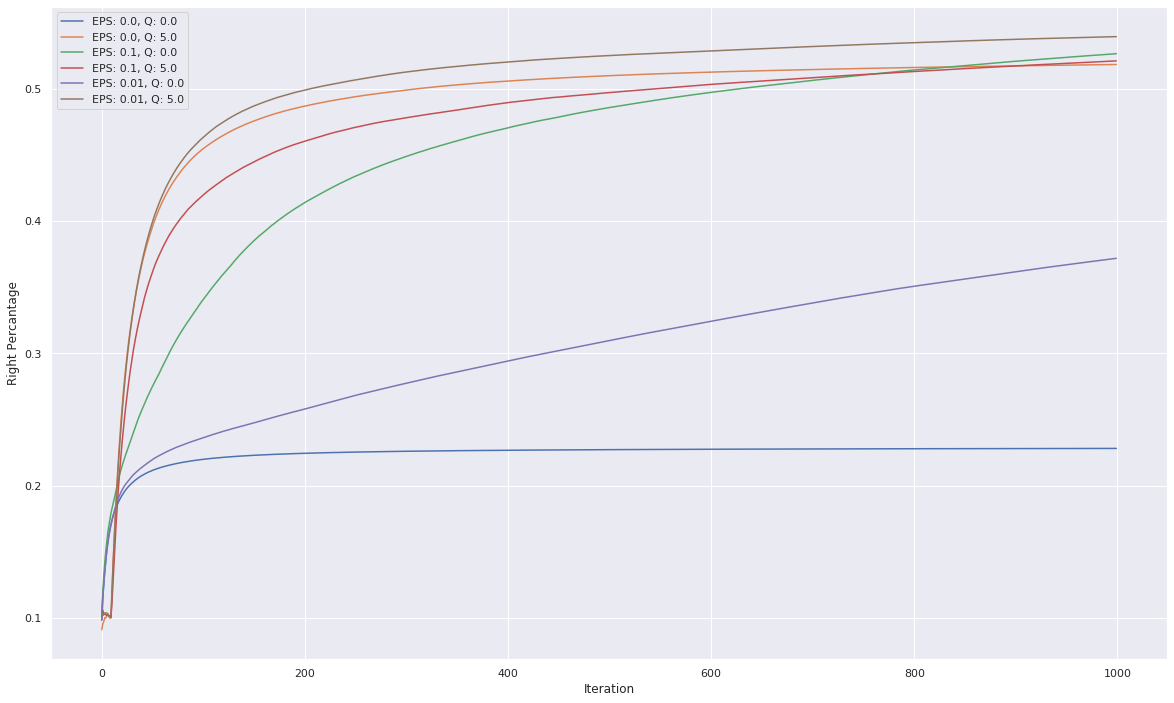

In [14]:
plt.figure(figsize=(20,12))
plt.xlabel('Iteration')
plt.ylabel('Right Percantage')
for i in range(result_df.shape[0]):
    sns.lineplot(data=result_df.iloc[i,3], 
                 label='EPS: {}, Q: {}'.format(result_df.iloc[i,0], result_df.iloc[i,1]))
    
plt.show()

\begin{align}
\ Value_j = \frac{\sum_{i=0}^{NExperiments}\sum_{t=0}^jreward_{i,t}}{NExperiments*j} \\
\end{align}

Where i - indexes over experiments, t - indexes over timestamps 

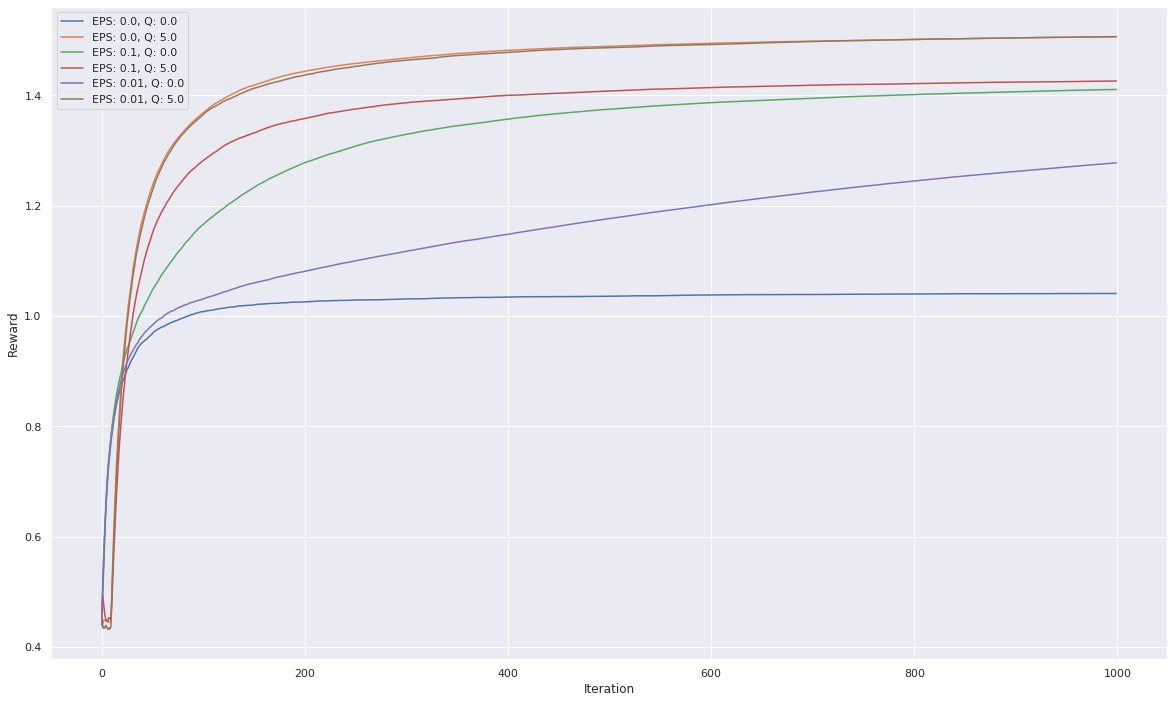

In [15]:
plt.figure(figsize=(20,12))
plt.xlabel('Iteration')
plt.ylabel('Reward')
for i in range(result_df.shape[0]):
    sns.lineplot(data=result_df.iloc[i,2], 
                 label='EPS: {}, Q: {}'.format(result_df.iloc[i,0], result_df.iloc[i,1]))
    
plt.show()

# MDP

### First Model

<br><strong>Object</strong> - Snake </br>
<br><strong>States</strong> - (x,y) coordinates </br>
<br><strong>Actions</strong> - turn up, turn down, turn left, turn right </br>
<br><strong>Reward</strong> - +1 for eaten apple </br>

### Second Model

<br><strong>Object</strong> - Letter classifier </br>
<br><strong>States</strong> - letter </br>
<br><strong>Actions</strong> - choose letter from dict </br>
<br><strong>Reward</strong> - +1 for correct classified letter </br>

## Third Model

<br><strong>Object</strong> - Taxi manager </br>
<br><strong>States</strong> - taxi cars </br>
<br><strong>Actions</strong> - choose passenger </br>
<br><strong>Reward</strong> - payment from passenger </br>